__Chapter 3 - A tour of machine learning classifiers using scikit-learn__

1. [Import](#Import)
1. [First steps with sklearn - training a perceptron](#First-steps-with-sklearn-training-a-perceptron)
1. [Modeling class probabilities w/ logistic regression](#Modeling-class-probabilities-w/-logistic-regression)
    1. [Intuition: logistic regression](#Intuition-logistic-regression)
        1. [Sigmoid function](#Sigmoid-function)
        1. [Decision function](#Decision-function)
    1. [Training a logistic regression model](#Training-a-logistic-regression-model)
1. [Maximum margin classification with SVMs](#Maximum-margin-classification-with-SVMs)
    1. [Intuition: SVMs](#SVM-intuition)
    1. [Nonlinearly separable cases and slack variables](#Nonlinearly-separable-cases-and-slack-variables)
    1. [Logistic regression vs. SVMs](#Logistic-regression-vs-SVMs)
    1. [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
    1. [$\gamma$ parameter](#gamma-parameter)
1. [Decision tree learning](#Decision-tree-learning)
    1. [Information gain](#Information-gain)
    1. [Combining decisions trees via random forests](#Combining-decisions-trees-via-random-forests)
1. [K-nearest neighbors](#K-nearest-neighbors)


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# First steps with sklearn - training a perceptron

<a id = 'First-steps-with-sklearn-training-a-perceptron'></a>

## Choosing a classifier
-Five key steps in training an algorithm
    1. Select features and collect training data
    2. Choose a performance metric
    3. Choose a classifier and optimization algorithm
    4. Evaluate model performance
    5. Tune the algorithm's parameters
Evaluate several different classifers.

<a id = 'Choosing-a-classifier'></a>

In [2]:
# load data and inspect class labels
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print("Class labels: {0}".format(np.unique(y)))

Class labels: [0 1 2]


In [3]:
# train/test split
# stratify ensures proportional distribution of classes between the train/test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

print("Label counts in y: {}".format(np.bincount(y)))
print("Label counts in y_train: {}".format(np.bincount(y_train)))
print("Label counts in y_test: {}".format(np.bincount(y_test)))

Label counts in y: [50 50 50]
Label counts in y_train: [35 35 35]
Label counts in y_test: [15 15 15]


In [4]:
# scale data
sc = preprocessing.StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
# review how first feature changes after standard scaling
print("Original mean: {0}".format(round(X_train[:, 0].mean(), 5)))
print("Original standard deviation: {0}".format(round(X_train[:, 0].std(), 5)))
print()
print("Scaled mean: {0}".format(round(X_train_std[:, 0].mean(), 5)))
print("Scaled standard deviation: {0}".format(round(X_train_std[:, 0].std(), 5)))

Original mean: 3.78952
Original standard deviation: 1.793

Scaled mean: 0.0
Scaled standard deviation: 1.0


> Remarks - Standard scaling uses the mean $\mu$ and standard deviation $\sigma$ to alter each feature independently such that each feature has a $\mu = 0$ and a $\sigma = 0$

> It is important to transform the test dataset using the fit performed on the training set only. First, we want the train and test data to be scaled in the same way. Further, we're assuming we don't know about the test data, and in practice new unseen data will need to be scaled based on the existing scaling operation defintions.

In [6]:
# instantiate Perceptron and fit model
ppn = linear_model.Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

> Remarks - 
- 'n_iter' limits the number epochs or iterations
- 'eta0' controls to learning rate. A value too high will likely overshoot the minimum. A value too low will make the learning process unnecessarily slow.

In [7]:
# predictions with misclassification score
y_pred = ppn.predict(X_test_std)
print("Misclassified samples: {0}".format((y_test != y_pred).sum()))

Misclassified samples: 1


>Remarks - 3 out of 45 samples are incorrectly predicted, yieled an misclassification percent of ~6.7%

In [8]:
# aAccuracy score
print("Accuracy: {}".format(round(metrics.accuracy_score(y_pred, y_test), 3)))

Accuracy: 0.978


In [9]:
# alternative 'score' method combines predict and accuracy_score
print("Accuracy: {}".format(round(ppn.score(X_test_std, y_test), 3)))

Accuracy: 0.978


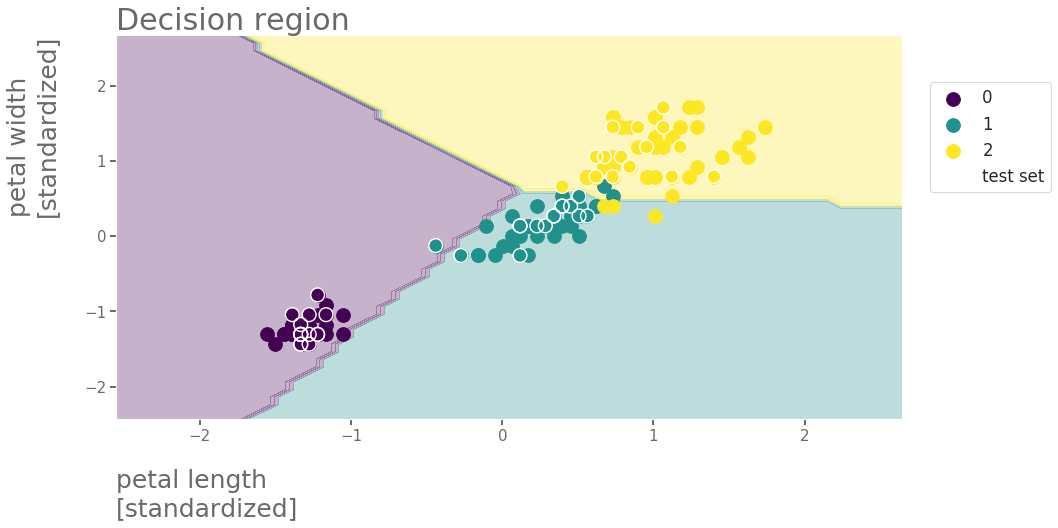

In [10]:
# plot decision region
p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.53,
)

X_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
p.decision_region(
    x=X_combined, y=y_combined, classifier=ppn, test_idx=range(105, 150), ax=ax
)

# Modeling class probabilities w/ logistic regression

<a id = 'Modeling-class-probabilities-w/-logistic-regression'></a>

## Intuition: logistic regression

Unlike actual regression, logistic regression doesn't try to predict the value of a number variable given an observation's inputs. Rather, logistic regression is a classification algorithm that returns a probability that an observation belongs to a certain class given an observation's inputs. In other words, logistic regression returns a value between 0 and 1, whereas actual regression returns a value between $-\infty$ and $\infty$.

The essence of returning a probability $p$ given a set of number and object attributes begins with the odds ratio, which describes the odds of a particular event occurring and returns a value in the range of 0 to $\infty$:

$$
\mbox{Odds ratio} = \frac{p}{(p - 1)}
$$

$p$ is the probability of an event occurring. As an example, the probability that a patient has diabetes given the patient's attributes. 

This can be further refined by taking the log of the odds ratio (the common convention is to use the natural log):

$$
logit(p) = log\frac{p}{(1 - p)}
$$

The logit function's purpose is to take a probability values between 0 and 1 and transforms them to values that range from $-\infty$ and $\infty$. A different way of looking at this is:

$$
logit\big(p(y = 1|\textbf{x})\big) = w_0x_0 + w_1x_1 + ... w_mx_m = \textbf{w}^T\textbf{x}
$$

Here, the conditional probability that a samples belongs to class 1 given its features $\textbf{x}$ is converted by the logit function from a number between 0 and 1 to a number between $-\infty$ and $\infty$. 

We can use these values to express a linear relationship between feature values and the log-odds. The RHS of the function, in a 3-dimensional example, would be a plane, which is used for separating classes in a 3-dimensional space. Observations can be very close or far away from the plane (or even on the plane), and that distance can inform the probability of an observation belonging to a certain class. Logistic regression seeks to describe that probability. To get this information, we use the inverse form of the logit function, called the logistic sigmoid function.

$$
\phi(z) = \frac{1}{1 + e^{-z}}
$$

$z$ is equal to $\textbf{w}^T\textbf{x}$

This technique can be used for binary classification and multi-class classification with a technique referred to as one-versus-rest.


<a id = 'Intuition-logistic-regression'></a>

### Sigmoid function

<a id = 'Sigmoid-function'></a>

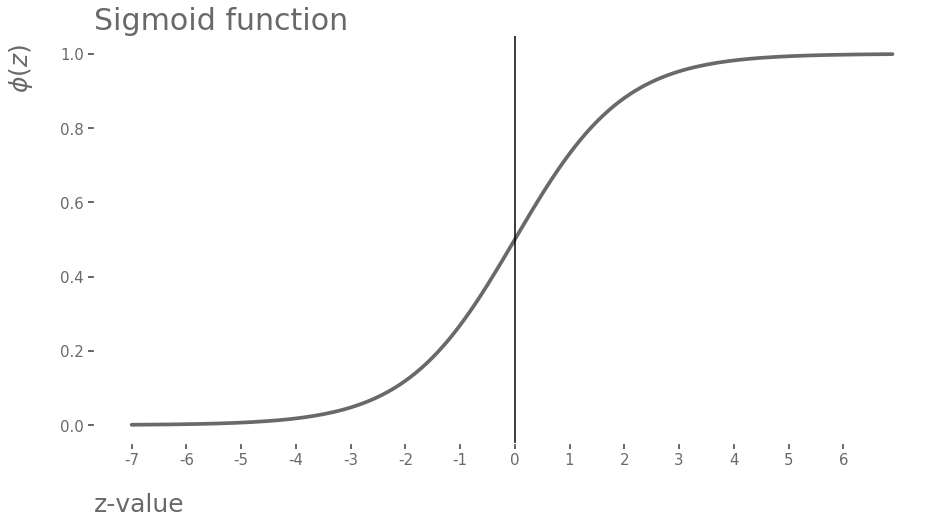

In [11]:
# visualize sigmoid function on the range -7 to 7
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


z = np.arange(-7, 7, 0.1)
z_phi = sigmoid(z)

p = PrettierPlot()
ax = p.make_canvas(
    title="Sigmoid function", x_label="z-value", y_label="$\phi (z)$", y_shift=0.86
)
p.line(x=z, y=z_phi, x_ticks=np.arange(-7, 7, 1.0), y_units="ff", ax=ax)
plt.axvline(0.0, color="black")

By reviewing this S-shaped curve it's clear that as $\phi(z)$ approaches 1, $z$ is approaching $\infty$ because $e^{-z}$ becomes very small for large values of $z$. Conversely, as $\phi(z)$ approaches 0, $z$ is approaching $-\infty$. 


### Decision function

<a id = 'Decision-function'></a>


The sigmoid functions also illustrates a key point from above: values between $-\infty$ and $\infty$ are converted to values between 0 and 1. These values between 0 and 1 are probabilities, and can be interpreted as the probability of a particular sample belonging to class 1 given an attribute input vector \textbf{x} and weight vector \textbf{w}. In mathematical notation:

$$
\phi(z)= P(y=1|\textbf{x};\textbf{w})
$$

For example, if $\phi(z)$ = 0.8, then there is an 80% chance that observation belongs to class 1, and a 20% chance of belonging to class 0. This conclusion is based on the decision function:

$$
\phi(z) =
\left\{
    \begin{array}{ll}
        1  & \mbox{if } \phi(z) >= 0.5 \\
        0  & \mbox{otherwise}
    \end{array}
\right.
$$

## Training a logistic regression model

<a id = 'Training-a-logistic-regression-model'></a>

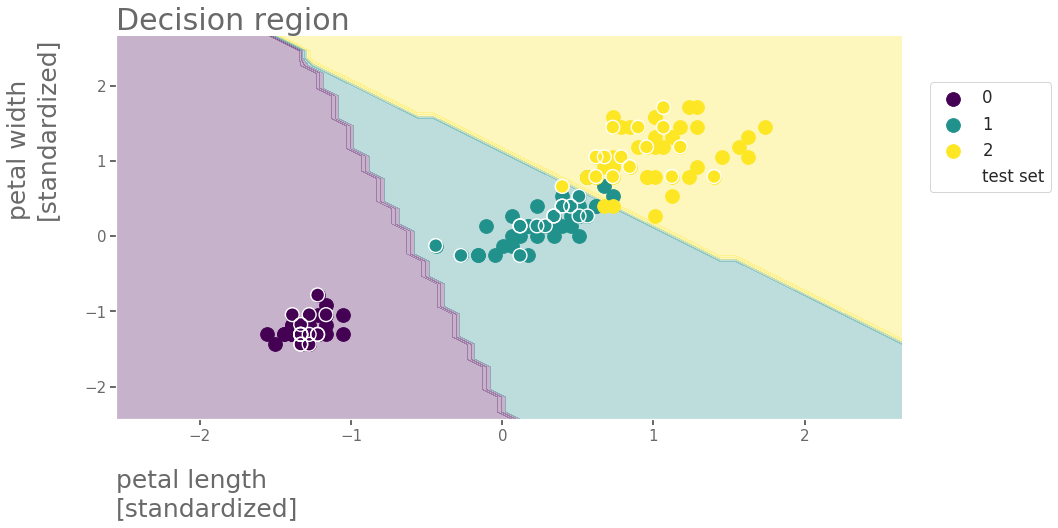

In [12]:
# plot decision region
log_reg = linear_model.LogisticRegression(C=100.0, random_state=1)
log_reg.fit(X_train_std, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.52,
    position=111,
)
p.decision_region(
    x=X_combined,
    y=y_combined,
    classifier=log_reg,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

In [13]:
# display probabilities associated with a few samples
log_reg.predict_proba(X_train_std[:3, :])

array([[0.81872665, 0.18127335, 0.        ],
       [0.76989578, 0.23010422, 0.        ],
       [0.00000004, 0.13151836, 0.8684816 ]])

> Remarks - There is an 81.9% chance sample 0 belongs to class 1, a 77.1% chance sample 2 belongs to class 0, and an 86.6% chance sample 3 belongs to class 2

In [14]:
# another way of illustrating to remark above
log_reg.predict_proba(X_train_std[:3, :]).argmax(axis=1)

array([0, 0, 2])

In [15]:
# we can also call the predict method on these samples
log_reg.predict(X_train_std[:3, :])

array([0, 0, 2])

## Use regularization to avoid overfitting

__Weight decay and $\lambda$__

A model that performs well on the training dataset but poorly on the test set is overfitting the data. Another way of saying this is that the model has high variance. These models often have too many parameters, leading to a very complex model.

Conversely, a model that underfits the data is not adequately capturing the pattern in the data, resulting in poor accuracy on both the training and test set. Underfit models are said to have high bias.

Regularization (also referred to as weight decay) is a method for reducing the complexity of a model. In short, regularization penalizes extreme weight values. A common form of regularization is L2 regularization:

$$
\lambda\sum\limits_{i=1}^{m}{w_i^2}
$$

where $\lambda$ is the regularization parameter that controls the strength of the penalty. Higher values of $\lambda$ lead to higher levels of regularization, and higher penalties for large weights.

__The parameter C__

The parameter C is the inverse of $\lambda$. Consequently, decreasing C increases the regularization strength

<a id = 'Use-regularization-to-avoid-overfitting'></a>

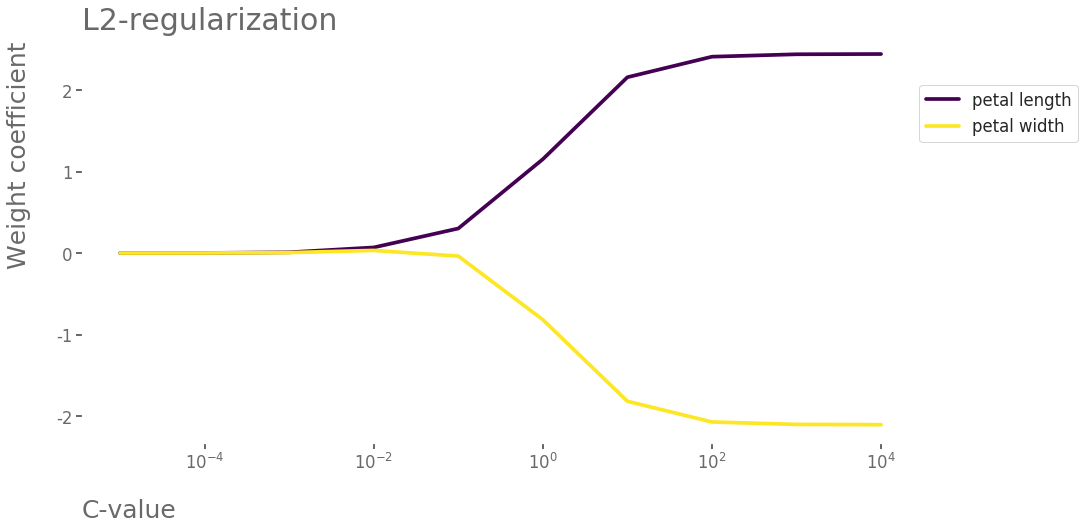

In [16]:
# visualize weight coefficient weights by regularization setting
weights, params = [], []
for c in np.arange(-5, 5):
    log_reg = linear_model.LogisticRegression(C=10.0 ** c, random_state=1)
    log_reg.fit(X_train_std, y_train)
    weights.append(log_reg.coef_[1])
    params.append(10.0 ** c)

p = PrettierPlot()
ax = p.make_canvas(
    title="L2-regularization",
    x_label="C-value",
    y_label="Weight coefficient",
    y_shift=0.43,
)
p.multi_line(
    x=np.array(params),
    y=np.array(weights),
    ax=ax,
    label=["petal length", "petal width"],
)
plt.xscale("log")

# Maximum margin classification with SVMs

SVMs are similar to the perceptron in that the goal is determine a boundary between clases. A key difference is that while the perceptron seeks to minimize classification error, SVMs seek to maximize the margin. The margin is the distance between the separating boundary (hyperplane) and the samples closest to that boundary. These samples are referred to as the support vectors.

In theory, maximizing margin distance leads to lower generalization error because hyperplanes with narrower distances are close to samples and therefore having higher variance and are more prone to overfitting.

<a id = '#Maximum-margin-classification-with-SVMs'></a>

## Intuition

One way to view that boundary is that there are actually three hyperplanes (in a binary classification problem):

1. Decision boundary
2. Positive hyperplane
3. Negative hyperplane

The first boundary is the object of the SVM, and the second two hyperplane are parallel to the decision boundary. These positive and negative boundaries are those closest to the positive and negative samples. A simple mathematical expression of these lines:

$$
w_0 + \textbf{w}^T\textbf{x}_{pos} = 1
$$
$$
w_0 + \textbf{w}^T\textbf{x}_{neg} = -1
$$

These linear equations can be subtract from each other, yielding:

$$
\textbf{w}^T\big(\textbf{x}_{pos} - \textbf{x}_{neg}\big) = 2
$$

Normalizing this equation by the length of the vector \texfbf{w}:

$$
\lVert\textbf{w}\rVert = \sqrt{\sum\nolimits_{j=1}^{m}w_j^2}
$$

Which can be transformed into the following equation:

$$
\frac{\textbf{w}^T\big(\textbf{x}_{pos} - \textbf{x}_{neg}\big)}{\lVert\textbf{w}\rVert} = \frac{2}{\lVert\textbf{w}\rVert}
$$
The LHS of the equation above is the distance between the positive and negative hyperplane. This is the margin that we want to maximize. The objective function of the SVM is to maximize that margin by maximizing the RHS subject the constraint that the samples are correctly classified:

$$
w_0 + \textbf{w}^T\textbf{x}^{(i)} \geq 1 \, if \, y^{(i)} = 1
$$

$$
w_0 + \textbf{w}^T\textbf{x}^{(i)} \leq -1 \, if \, y^{(i)} = -1
$$

$$
\mbox{for} \, i = 1...N
$$

where N is the number of samples in the dataset. The equation above essentially say that all positive samples should fall on one side of the positive hyperplane, and all negative samples on one side of the negative hyperplane. Those two key equations can be written compactly as:

$$
y^i\big(w_0 + \textbf{w}^T\textbf{x}^i\big) \geq 1\forall_i
$$


<a id = 'SVM-intuition'></a>

## Nonlinearly separable cases and slack variables

To scratch the surface on soft-margin classification, which allows for a certain level of misclassificaiton tolerance through the slack variable $\xi$. This is helpful in cases where the data is not completely linearly separable. To accomplish this, the slack variable is added to the linear constraints described earlier:

$$
w_0 + \textbf{w}^T\textbf{x}^{(i)} \geq 1 - \xi^{(i)} \, if \, y^{(i)} = 1
$$

$$
w_0 + \textbf{w}^T\textbf{x}^{(i)}\leq - 1 + \xi^{(i)} \, if \, y^{(i)} = -1
$$

$$
\mbox{for} \, i = 1...N
$$

$N$ is again the number of samples in the dataset. The New objective function to minimize is:

$$
\frac{1}{2}\lVert\textbf{w}\rVert + C \bigg(\sum_{i}\xi^{(i)}\bigg)
$$

The variable $C$ controls the penalty for misclassification. Larger values of $C$ correspond to larger error penalties, making the algorithm less forgiving of misclassifications. The model will choose narrower boundaries with higher variance in its efforts to minimize error. Smaller variables of $C$ will be more forgiving of errors and may find a boundary with a wider margin and lower variance.

<a id = 'Nonlinearly-separable-cases-and-slack-variables'></a>

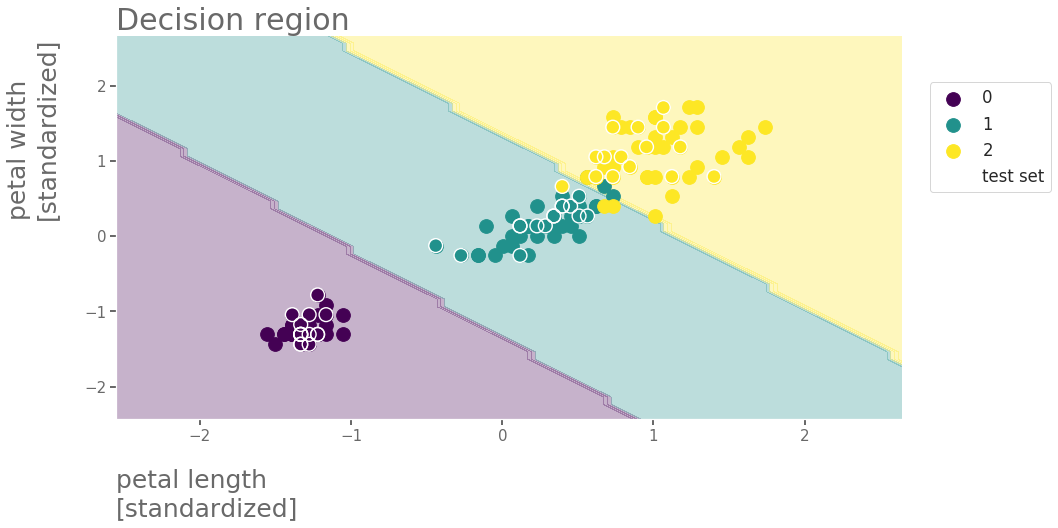

In [17]:
# plot decision region
sv = svm.SVC(kernel="linear", C=1.0, random_state=1)
sv.fit(X_train_std, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.52,
)
p.decision_region(
    x=X_combined, y=y_combined, classifier=sv, test_idx=range(105, 150), ax=ax
)

## Logistic regression vs. SVMs

Logistic regression and SVMs often produce similar results, but there are a few fundamental differences. 
- Since SVMs are only interested in finding support vectors (samples closest to the boundary), it is generally  not influenced by outlier. the same cannot be said for logistic regression.
- Logistic regression is a simpler model mathematically and can be implemented more easily.
- Logistic regression models can be easily updated with new data.

<a id = 'Logistic-regression-vs-SVMs'></a>

## Solving nonlinear problems using a kernel SVM

It is often impossible to separate data points with a line, plane or hyperplane, making logistic regression and SVM incapable of finding a meaningful solution. One potential solution is to use a kernel method to create nonlinear combinations of the original features and project the observations onto a higher-dimensional space via a mapping function $\phi$ where it becomes linearly separable.

$$
\phi(x_1,x_2) = (z_1,z_2,z_3) = (x_1,x_2,x_1^2,x_1^2)
$$

This enables us to separate two non-linearly separable classes with a linear hyperplane that becomes a nonlinear decision boundary when projected back onto the original feature space.

In practice, the training data is mapped to a higher-dimension space using the mapping function $\phi$, and then unseen data is mapped using the same function to classifiy it using the linear SVM model.

The kernel trick is a solution to high computation expense of creating new features, which is especially high when dealing with high-dimensional data. The operation of finding the dot product with $\textbf{x}^{(i)T}\textbf{x}^{(j)}$ by wrapping each vector with our function $\phi$: $\phi\big(\textbf{x}^{(i)T}\big)\phi\big(\textbf{x}^{(j)}\big)$. This kernel function avoids the otherwise expensive calculation step of calcuting the dot product of two points explicitely:

$$
K(\textbf{x}^{(i)},\textbf{x}^{(j)}) = \phi\big(\textbf{x}^{(i)T}\big)\phi\big(\textbf{x}^{(j)}\big)
$$

A widely used kernel trick is called the radial basis function (RBF) or the Gaussian kernel:

$$
K(\textbf{x}^{(i)},\textbf{x}^{(j)}) = \mbox{exp}\Bigg(-\frac{\lVert\textbf{x}^{(i)} - \textbf{x}^{(j)}\rVert}{2\sigma^2}\Bigg)
$$

Which simplifies to:

$$
K(\textbf{x}^{(i)},\textbf{x}^{(j)}) = \mbox{exp}\Big(-\gamma\lVert\textbf{x}^{(i)} - \textbf{x}^{(j)}\rVert^2\Big)
$$

The parameter $\gamma$ = $\frac{1}{2\sigma^2}$ and is tuned udring optimization.

A kernel is a similarity function in that it evaluates a pair of samples. The minus sign in front of $\gamma$ inverts the distance measure into a similarity score (high values, or less negative values, represent more similar observations). The exponential term ensures the similarity score falls between 1 (exactly similar samples) and 0 (very dissimilar samples).

<a id = 'Solving-nonlinear-problems-using-a-kernel-SVM'></a>

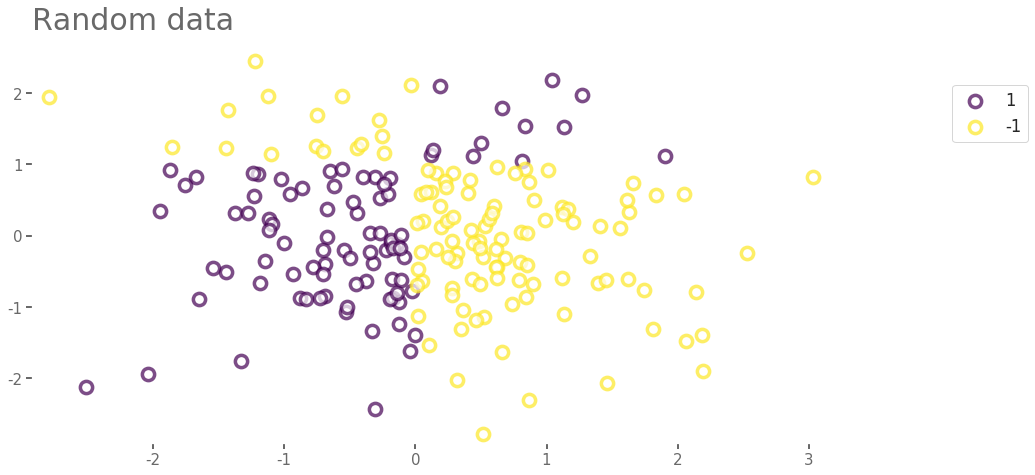

In [18]:
# plot non-linearly separable data
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 1)

p = PrettierPlot()
ax = p.make_canvas(title="Random data")
p.scatter_2d_hue(
    x=X_xor[:, 0],
    y=X_xor[:, 1],
    target=y_xor,
    label=["1", "-1"],
    x_units="f",
    y_units="f",
    ax=ax,
)

Remarks - Clearly non-linearly separable class

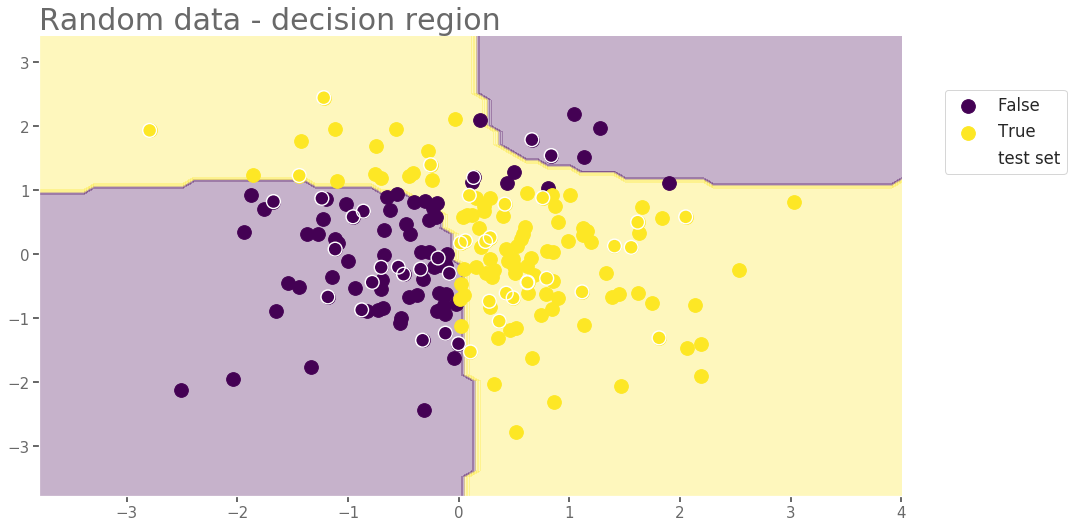

In [19]:
# plot decision region
sv = svm.SVC(kernel="rbf", random_state=1, gamma=0.10, C=10.0)
sv.fit(X_xor, y_xor)

p = PrettierPlot()
ax = p.make_canvas(title="Random data - decision region")
p.decision_region(
    x=X_xor, y=y_xor, classifier=sv, test_idx=range(105, 150), bbox=(1.2, 0.9), ax=ax
)

## $\gamma$ parameter

The parameter gamma $\gamma$ is a cut-off parameter for the Gaussian sphere. Increasing the value of $\gamma$ increasing the influece of the training samples, which leads to a tighter and bumpier decision boundary. 

<a id = 'gamma-parameter'></a>

In [20]:
# plot decision region
sv = svm.SVC(kernel="rbf", random_state=1, gamma=0.2, C=1.0)
sv.fit(X_train_std, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.52,
)
p.decision_region(
    x=X_combined,
    y=y_combined,
    classifier=sv,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

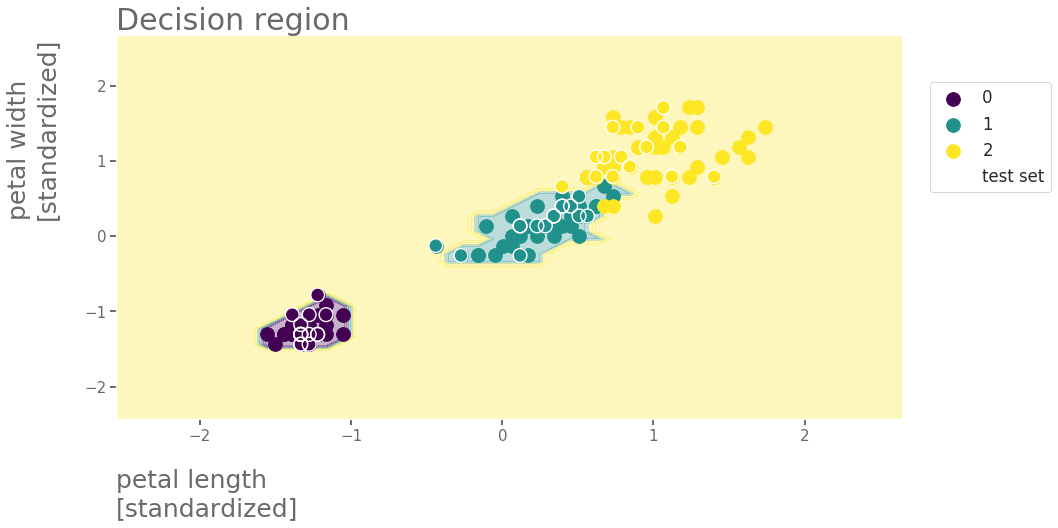

In [21]:
# plot decision region
sv = svm.SVC(kernel="rbf", random_state=1, gamma=100.0, C=1.0)
sv.fit(X_train_std, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.52,
)
p.decision_region(
    x=X_combined,
    y=y_combined,
    classifier=sv,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

> Remarks - The two graphs above clearly illustrate that higher values for $\gamma$ yield tight decision boundaries. While the second graph appears to be highly accurate, this model appears to be overfitting the data and has high variance. It will likely not perform well on unseen data.

# Decision tree learning

Decision trees are comprised of a series of sequential questions. Each node in the tree involves a feature and a rule which dictates how observations are separated based on the observations' values for that feature. Decision trees are typically easy to interpret and visualize, and do not require feature scaling.

Beginning at the root, which holds all features in the dataset, the decision algorithm splits the observation of the feature that results in the largest information gain. A node is split into child nodes in succession until all of the bottom-most leaves are pure, meaning only one type of class is represented. As models that proceed to this level are often very deep and overfit, regularization is a key part of the decision tree building process.

<a id = 'Decision-tree-learning'></a>

## Information gain

To split the nodes on the most informative features, we define an optimization function. The goal is to maximize the information gain at each split:

$$
IG(D_p,f) = I(D_p) - \sum^{m}_{j=1}\frac{N_j}{N_p}I(D_j)
$$

In this equation: 
* $f$ is feature to split
* $D_p$ and $D_j$ are dataset of the parent node and the $j$th node
* $I$ is the impurity measure
* $N_j$ is the number of samples in the $j$th child node

The information gain is the difference between the impurity of the parent node and the sum of the child node impurities. The lower the impurity of the child nodes, the larger the information gain.

Most libraries, including sklearn implement binary trees, where each parent node is split into two child nodes, $D_{left}$ and $D_{right}$:

$$
IG(D_p,f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})
$$

There are two key impurity measures (splitting criteria):

__Entropy__ ($I_H$)

$$
I_H(t) = - \sum_{i = 1}^{c}p(i \lvert t)\mbox{log}_2p(i \lvert t)
$$

This is the definition of entropy for all non-empty classes. $p(i \lvert t)$ is the proportion of the samples that belong to class $c$ for a particular node $t$. The entropy is 0 if all samples belong to the same class. The entropy is 1 if the number of samples in each class is the same.

__Gini impurity__ ($I_G$)

$$
I_G(t) = \sum_{i = 1}^{c}p(i \lvert t)\big(1 - p(i \lvert t)\big) = 1 - \sum_{i = 1}^{c}p(i \lvert t)^2
$$

The Gini impurity is a criterion that seeks to minimize the probability of misclassification. Similar to entropy, Gini impurity is highest when the classes are evenly mixed.

See page 93 for detailed examples.

<a id = 'Information-gain'></a>

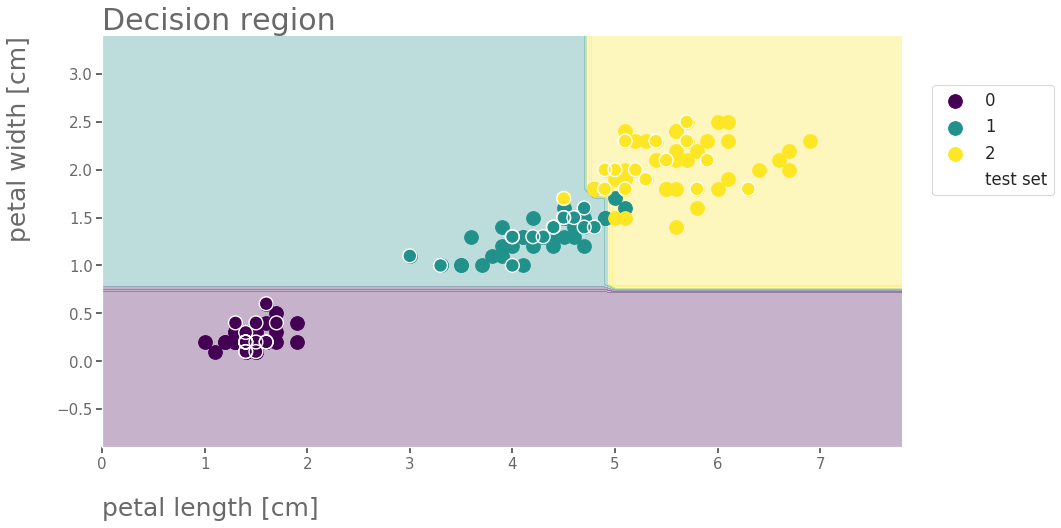

In [22]:
# plot decision region
dec_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1)
dec_tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length [cm]",
    y_label="petal width [cm]",
    y_shift=0.5,
)
p.decision_region(
    x=X_combined,
    y=y_combined,
    classifier=dec_tree,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

## Combining decisions trees via random forests

Random forests are an ensemble of individual decision trees. The intent it to average multiple, and typically deep decision trees that  individually have high variance but when combined exhibit better generalization and are less prone to overfitting. The steps for creating a Randon Forest are:

1. Draw a random boostrap (with replacement) sample of size $n$
2. Create a decision tree with the bootstrap sample. At each node
    
    a. Randomly select $d$ features (no replacement)
    
    b.  Among the $d$ features, split the node using the feature that provides the best split per the objective function.

3. Repeats steps 1 & 2 $k$, which is the number of tree to build
4. The prediction for each samples is bsaed on the majority vote among all of the trees made during steps 1,2 & 3.

Parameter tuning with Random Forests is less important than with individual decisions trees because the majority vote amongst all of the trees tends to deal with the noise emanating from the individual trees. That being said, interesting results can be achieved by performing tuning of a few parameters in particular. For example, decreasing the size of the boostrap sample limits the proportion of that dataset that the decision tree algorithm is able to see, which increases the diversity of the individual trees. This may, in effect, reduce the overfitting of the model.

<a id = 'Combining-decisions-trees-via-random-forests'></a>

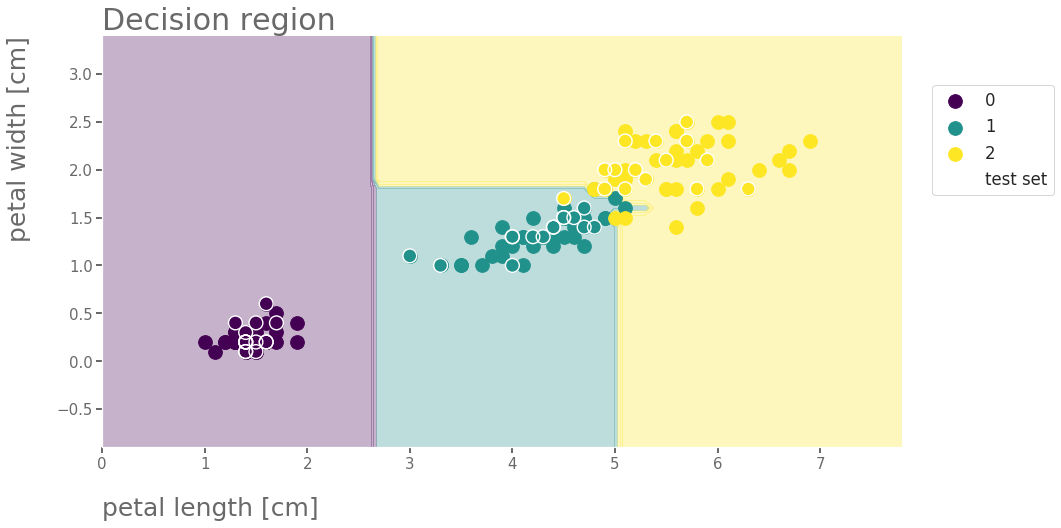

In [23]:
# craete random forest model
forest = ensemble.RandomForestClassifier(
    criterion="gini", n_estimators=25, random_state=1, n_jobs=2
)
forest.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# plot decision region
p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length [cm]",
    y_label="petal width [cm]",
    y_shift=0.5,
)
p.decision_region(
    x=X_combined,
    y=y_combined,
    classifier=forest,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

# K-nearest neighbors

KNN is a classifier that is regarded as lazy, meaning it doesn't learn anything from the data, but memorizes the data instead. The algorithm is straightforward:

1. Choose a number for $k$ and a distance metric
2. Find the $k$-nearest neighbors of the sample that we are trying to classify
2. Assign the class label by majority vote.

This has the advantage that it adapts as new training data is collect. The major downside is the fact that the computation complexity of the algorithm gorws with the size of the dataset. There isn't a training set in the sense that we have been using that term.


<a id = 'K-nearest-neighbors'></a>

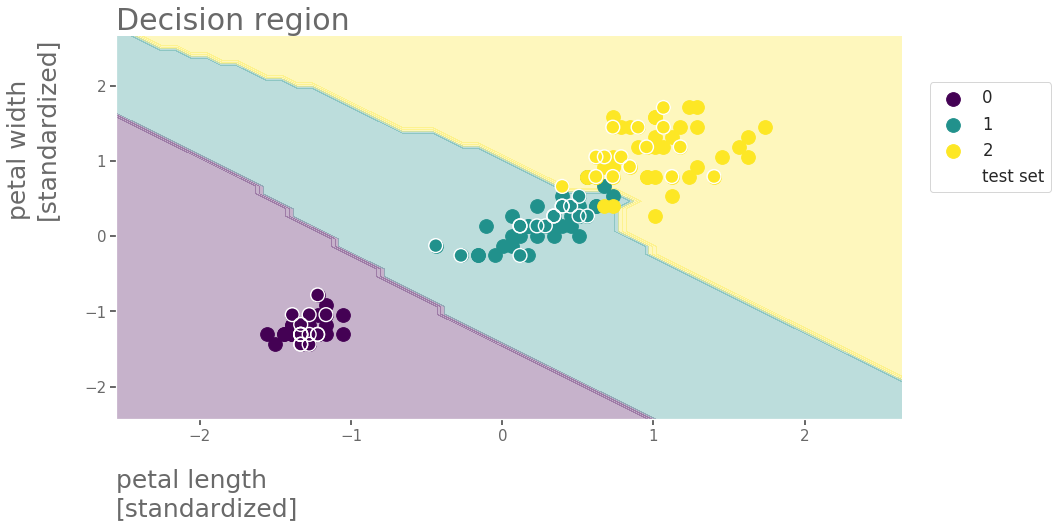

In [29]:
# plot decision region
knn = neighbors.KNeighborsClassifier(n_neighbors=5, p=2, metric="minkowski")
knn.fit(X_train_std, y_train)

p = PrettierPlot()
ax = p.make_canvas(
    title="Decision region",
    x_label="petal length \n[standardized]",
    y_label="petal width \n[standardized]",
    y_shift=0.52,
)
X_combined_std = np.vstack((X_train_std, X_test_std))
p.decision_region(
    x=X_combined_std,
    y=y_combined,
    classifier=knn,
    test_idx=range(105, 150),
    bbox=(1.2, 0.9),
    ax=ax,
)

The trick is to find the right choice of $k$, and this is a parameter that should be tuned. We also can choose which distance metric we want to use. In the example above, minkowski distance is used:

$$
d\big(x^{(i)},x^{(i=j)}\big) = \sqrt[p]{\sum_k\lvert x_k^{(i)} - x_k^{(j)} \rvert^p}
$$

Minkowski distance becomes Manhatten distance when $p$ = 1 and Euclidean distance when $p$ = 2.

KNN is very susceptible to overfitting due to the curse of dimensionality. This curse describes what happens when the feature space becomes increasingly sparse as features are added to a training set of fixed-size. What this means for KNN is that even the neighbors of a sample can be very far away, preventing the algorithm from finding good estimates. In this case, dimensionality reduction should be explored.